In [1]:
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt
from utilitiesDOS import read_dump, calculate_fft, calculate_autocorr

In [2]:
import os, sys, git
sys.path.append('pyplot-perso/')
from functions import complete_panel, save_figure, set_boundaries, \
    add_subplotlabels, set_boundaries, prepare_figure
from color_series1 import colors
path_figures = "/figures/"

In [3]:
current_path = os.getcwd()
git_repo = git.Repo(current_path, search_parent_directories=True)
git_path = git_repo.git.rev_parse("--show-toplevel")
sys.path.append(git_path)

### Import LAMMPS velocities

In [4]:
path_to_file = "LAMMPS-input/dump.lammpsvel"
velocities, n_atoms, n_frames, n_columns, printing_period = read_dump(path_to_file)
print("Shape of the velocities array =", np.shape(velocities))
print("Number of frames =", n_frames)
print("Number of particles =", n_atoms)

Shape of the velocities array = (850, 3, 2001)
Number of frames = 2001
Number of particles = 850


### Choose correlation length

In [5]:
correlation_len = n_frames // 4
print("Correlation length =", correlation_len)

Correlation length = 500


### Set timestep

In [6]:
dt = 2.32 # fs
min_dt = dt * printing_period # duration between two printed velocity
print("The velocities was printed every", min_dt, "fs")

The velocities was printed every 11.6 fs


### Calculate VACF

In [7]:
vacf_xyz = np.zeros((3, correlation_len), dtype=float)
vacf = np.zeros((correlation_len), dtype=float)  
for i_time in range(correlation_len, n_frames, correlation_len):
    for i_atom in range(n_atoms):
        for i_dim in range(3):
            vacf_xyz[i_dim] += calculate_autocorr(velocities[i_atom,
                                                             i_dim,i_time-correlation_len:i_time],
                                                   correlation_len)
for vxyz in vacf_xyz: # Average all 3 direction
    vacf += vxyz
vacf /= vacf[0] # Normalize the velocity correlation
time = np.arange(len(vacf)) * min_dt # fs
time /= 1000 # ps

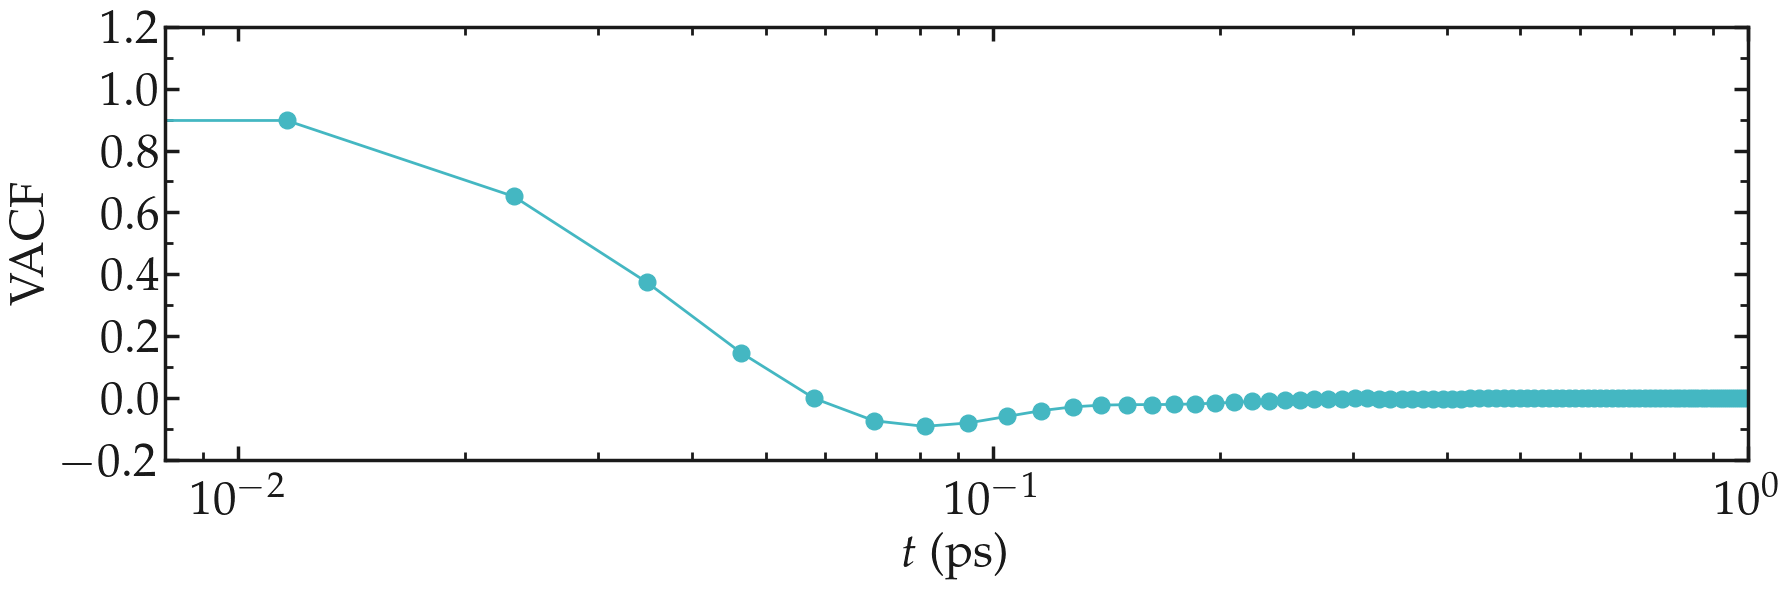

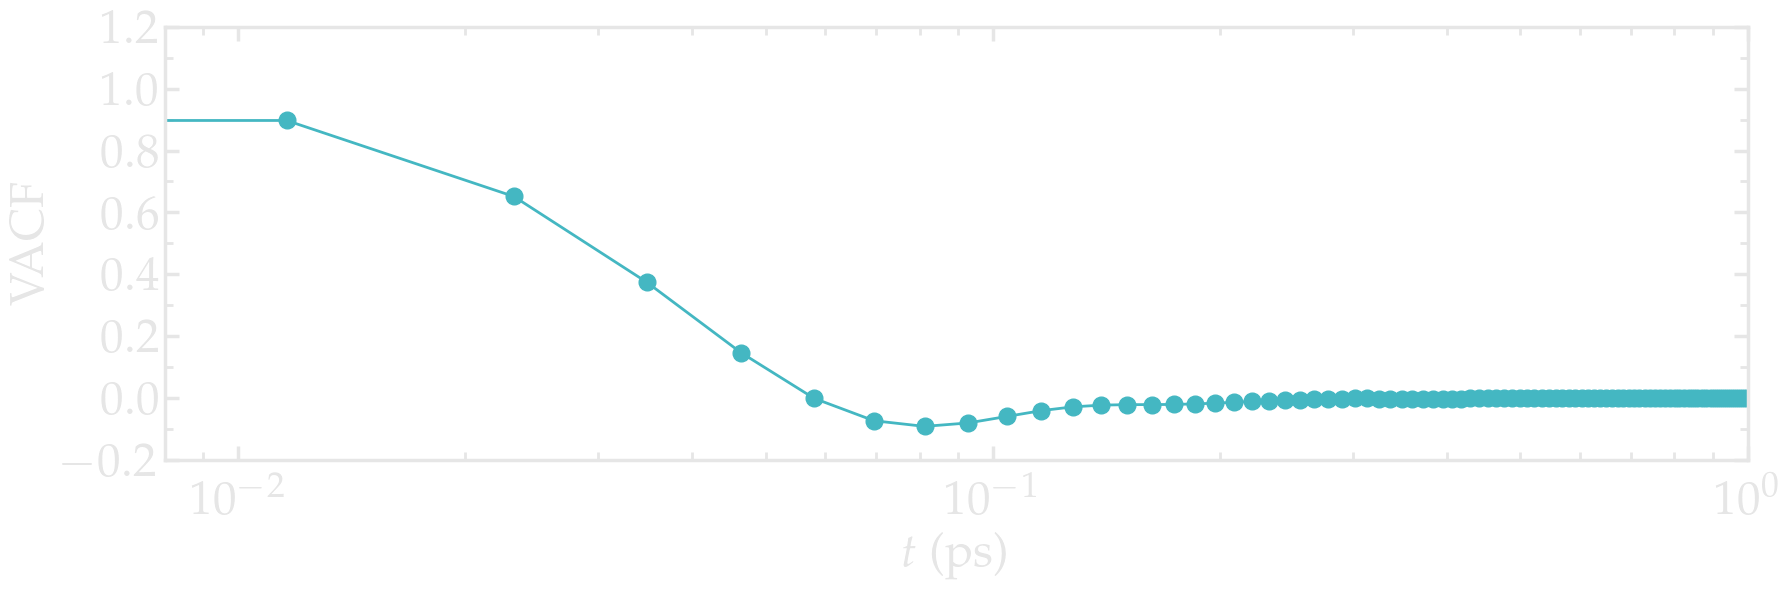

In [8]:
filename = "vacf"
desired_transparency = True
for mode, mygray in zip(['light', 'dark'], [colors["mylightgray"], colors["mydarkgray"]]):    
    fig = prepare_figure(mode, transparency=desired_transparency, desired_figsize=(18,6))
    ax, n, l_tot, c_tot = [], 0, 1, 1
    n += 1
    ax.append(plt.subplot(l_tot, c_tot, n))
    ax[-1].semilogx(time, vacf, 'o-', color=colors["mycyan"],
                markersize = 12, linewidth=2)
    complete_panel(ax[-1], r'$t$ (ps)', r'$\textrm{VACF}$',
                   legend=False, axis_color=mygray, xpad=15, locator_x=None)
    set_boundaries(plt, x_boundaries=(0.008, 1), y_boundaries=(-0.2, 1.2)) 
    save_figure(plt, fig, mode, git_path, path_figures, filename, transparency = desired_transparency)

### Calculate DOS

In [10]:
freq, dos = calculate_fft(time, vacf).T

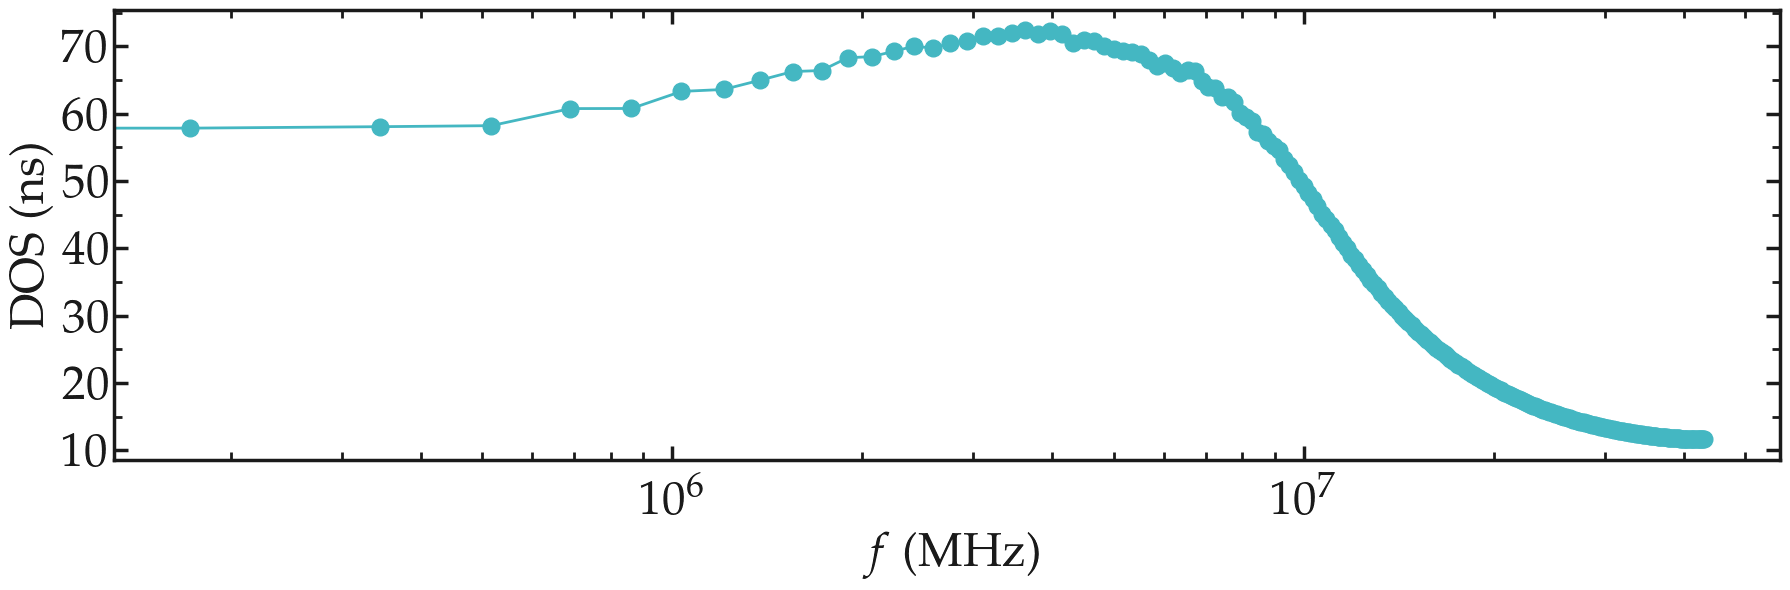

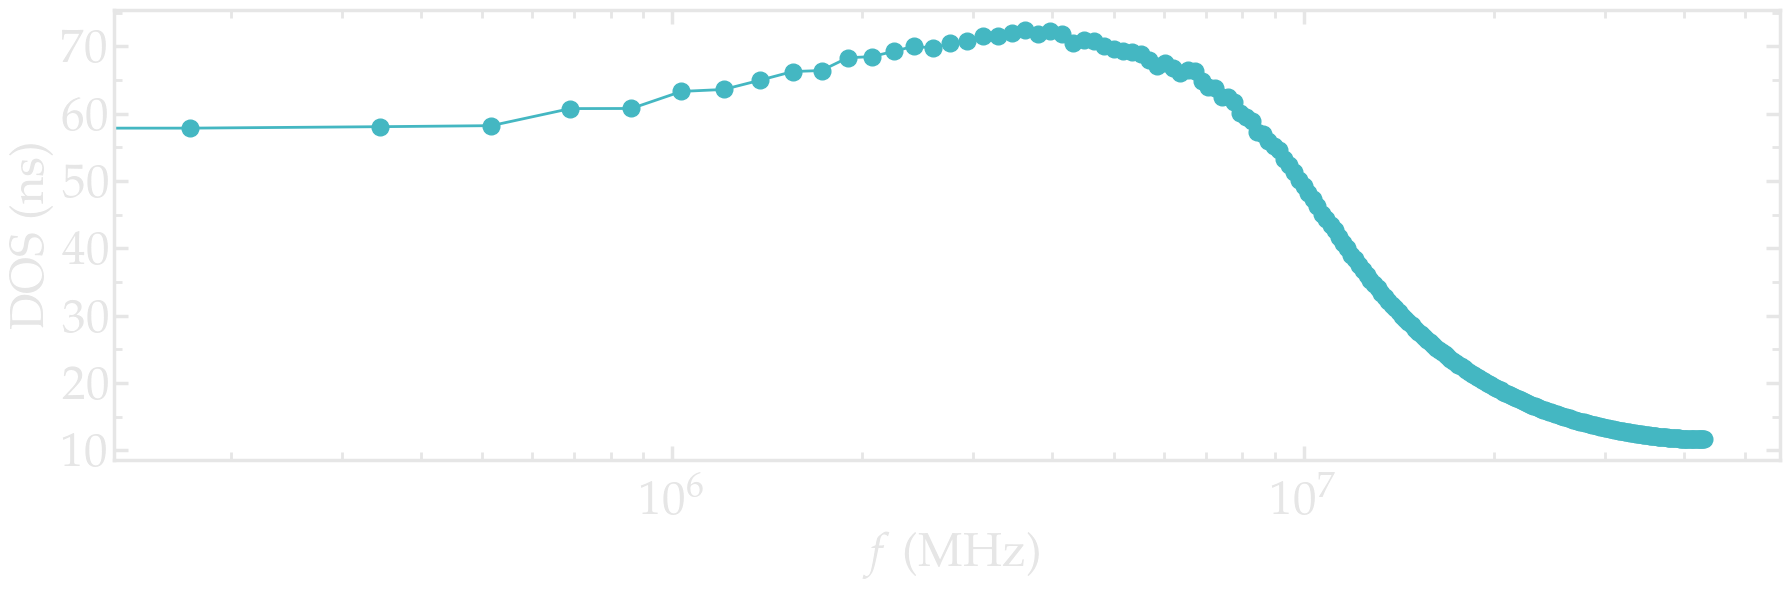

In [15]:
filename = "dos"
desired_transparency = True
for mode, mygray in zip(['light', 'dark'], [colors["mylightgray"], colors["mydarkgray"]]):    
    fig = prepare_figure(mode, transparency=desired_transparency, desired_figsize=(18,6))
    ax, n, l_tot, c_tot = [], 0, 1, 1
    n += 1
    ax.append(plt.subplot(l_tot, c_tot, n))
    ax[-1].semilogx(freq, dos*1000, 'o-', color=colors["mycyan"],
                markersize = 12, linewidth=2)
    complete_panel(ax[-1], r'$f$ (MHz)', r'$\textrm{DOS}$ (ns)',
                   legend=False, axis_color=mygray, xpad=15, locator_x=None)
    # set_boundaries(plt, x_boundaries=(8, 1000), y_boundaries=(-0.2, 1.2)) 
    save_figure(plt, fig, mode, git_path, path_figures, filename, transparency = desired_transparency)